<a href="https://colab.research.google.com/github/farid-hamid/FinalYearProjectFH/blob/main/BERTopic%20Model%20%2B%20Classifiers%20v7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **NLP Model Framework** 🔡📊
---
*This notebook consists and demonstrates a working NLP model framework consisting of an unsupervised learning stage (extracting and labelling topics from a text corpus) and a supervised stage (multi topic text classification). The text corpus consists of posts and comments from popular Diabetes based subReddits where the discussion of Continuous Glucose Monitoring systems and devices are common.*

# **Initial Importing & pip installation of relevant libraries**

In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from matplotlib import pyplot as plt
import seaborn as sns
import re

In [2]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
import string

In [4]:
import nltk

In [5]:
%pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 5.6 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86832 sha256=379cdaaf637c2a70727281c9b2a658a7220b67f3452f1825e8e4f0e9507efa5b
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
Successfully built umap-learn


In [6]:
%pip install HDBSCAN

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 13.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached Cython-0.29.37-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
  Created wheel for HDBSCAN: filename=hdbscan-0.8.33-cp310-cp310-linux_x86_64.whl size=3039271 sha256=4d6de500707fb9ff44759dd2e1f62e35841ebdedb363de28e6b14ab50c09fd82
  Stored in directory: /root/.cache/pip/wheels/75/0b/3b/dc4f60b7cc455efaefb62883a7483e76f09d06ca81cf87d610
Successfully built HDBSCAN
  Attempting uninstall: cython
    Found existing installation: Cython 3.0.8
    Uninstalling Cython-3.0.8:
      Successfully uninstalled Cython-3.0.8


# **Data Cleaning and Natural Language Processing**
*Preparing the text corpus for upcoming topic modelling by normalising the data, removing polluting elements of user-generated data and appropriating document length using spaCy.*

In [7]:
df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Unlabelled Discussion DATA.xlsx')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   subReddit            1200 non-null   object        
 1   Date                 1200 non-null   object        
 2   Datetime             1200 non-null   datetime64[ns]
 3   Title                1194 non-null   object        
 4   Body Text            929 non-null    object        
 5   Top Comment          91 non-null     object        
 6   Top Comment Reply 1  25 non-null     object        
 7   Top Comment Reply 2  10 non-null     object        
 8   Top Comment Reply 3  0 non-null      float64       
 9   Top Comment Reply 4  0 non-null      float64       
dtypes: datetime64[ns](1), float64(2), object(7)
memory usage: 93.9+ KB


In [8]:
df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   subReddit            1200 non-null   object        
 1   Date                 1200 non-null   object        
 2   Datetime             1200 non-null   datetime64[ns]
 3   Title                1194 non-null   object        
 4   Body Text            929 non-null    object        
 5   Top Comment          91 non-null     object        
 6   Top Comment Reply 1  25 non-null     object        
 7   Top Comment Reply 2  10 non-null     object        
 8   Top Comment Reply 3  0 non-null      float64       
 9   Top Comment Reply 4  0 non-null      float64       
dtypes: datetime64[ns](1), float64(2), object(7)
memory usage: 93.9+ KB


In [9]:
data = df

In [10]:
data.head()

,subReddit,Date,Datetime,Title,Body Text,Top Comment,Top Comment Reply 1,Top Comment Reply 2,Top Comment Reply 3,Top Comment Reply 4
0,diabetes_t2,2023-12-05 00:00:00,2023-12-05 23:25:00,Cheapest way to get a CGM without insurance?,Well after being told my insurance would cover...,NaN,NaN,NaN,NaN,NaN
1,diabetes_t2,2023-12-20 00:00:00,2023-12-20 05:13:00,Libre 3 doesn’t stick,I’ve used the Libre 3 for 3 months off and on....,NaN,NaN,NaN,NaN,NaN
2,diabetes_t2,2023-12-23 00:00:00,2023-12-23 23:16:00,Frustrated with Libre 3,I just got off the phone with customer support...,NaN,NaN,NaN,NaN,NaN
3,diabetes_t2,2023-12-23 00:00:00,2023-12-23 02:32:00,Libre 3 Graphs 3 weeks in,The first graph was my first full day with my ...,NaN,NaN,NaN,NaN,NaN
4,diabetes_t2,2023-12-07 00:00:00,2023-12-07 16:34:00,Confused by GMI on Libre 3,I'm finding myself confused by the GMI measure...,NaN,NaN,NaN,NaN,NaN


In [11]:
n = len(data)

In [12]:
data.drop(['Date', 'Datetime'], axis=1)


,subReddit,Title,Body Text,Top Comment,Top Comment Reply 1,Top Comment Reply 2,Top Comment Reply 3,Top Comment Reply 4
0,diabetes_t2,Cheapest way to get a CGM without insurance?,Well after being told my insurance would cover...,NaN,NaN,NaN,NaN,NaN
1,diabetes_t2,Libre 3 doesn’t stick,I’ve used the Libre 3 for 3 months off and on....,NaN,NaN,NaN,NaN,NaN
2,diabetes_t2,Frustrated with Libre 3,I just got off the phone with customer support...,NaN,NaN,NaN,NaN,NaN
3,diabetes_t2,Libre 3 Graphs 3 weeks in,The first graph was my first full day with my ...,NaN,NaN,NaN,NaN,NaN
4,diabetes_t2,Confused by GMI on Libre 3,I'm finding myself confused by the GMI measure...,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
1195,diabetes_t2,Morning Spikes,Anyone else get 60/70 point increases in the m...,NaN,NaN,NaN,NaN,NaN
1196,diabetes_t2,This is what severe anxiety does to my blood s...,I did not eat any carbs with either of those ...,NaN,NaN,NaN,NaN,NaN
1197,diabetes,I tried having it on my arm just once as sugge...,The filament bent like 15 minutes after I've p...,NaN,NaN,NaN,NaN,NaN
1198,diabetes,"Mine keeps breaking, on my right arm.",I have had 3 break and stop reading.,NaN,NaN,NaN,NaN,NaN


In [13]:
#stage 1 lowercase
data['Title'] = data['Title'].str.lower()
data['Body Text'] = data['Body Text'].str.lower()
data['Top Comment'] = data['Top Comment'].str.lower()
data['Top Comment Reply 1'] = data['Top Comment Reply 1'].str.lower()
data['Top Comment Reply 2'] = data['Top Comment Reply 2'].str.lower()
#data['Top Comment Reply 3'] = data['Top Comment Reply 3'].str.lower()
#data['Top Comment Reply 4'] = data['Top Comment Reply 4'].str.lower()

In [14]:
data.head()

,subReddit,Date,Datetime,Title,Body Text,Top Comment,Top Comment Reply 1,Top Comment Reply 2,Top Comment Reply 3,Top Comment Reply 4
0,diabetes_t2,2023-12-05 00:00:00,2023-12-05 23:25:00,cheapest way to get a cgm without insurance?,well after being told my insurance would cover...,NaN,NaN,NaN,NaN,NaN
1,diabetes_t2,2023-12-20 00:00:00,2023-12-20 05:13:00,libre 3 doesn’t stick,i’ve used the libre 3 for 3 months off and on....,NaN,NaN,NaN,NaN,NaN
2,diabetes_t2,2023-12-23 00:00:00,2023-12-23 23:16:00,frustrated with libre 3,i just got off the phone with customer support...,NaN,NaN,NaN,NaN,NaN
3,diabetes_t2,2023-12-23 00:00:00,2023-12-23 02:32:00,libre 3 graphs 3 weeks in,the first graph was my first full day with my ...,NaN,NaN,NaN,NaN,NaN
4,diabetes_t2,2023-12-07 00:00:00,2023-12-07 16:34:00,confused by gmi on libre 3,i'm finding myself confused by the gmi measure...,NaN,NaN,NaN,NaN,NaN


In [15]:
data.fillna('', inplace=True)
data['Discussion'] = data.apply(lambda row: ' '.join(row[['Title', 'Body Text', 'Top Comment']].values), axis=1)

In [16]:
data.head()

,subReddit,Date,Datetime,Title,Body Text,Top Comment,Top Comment Reply 1,Top Comment Reply 2,Top Comment Reply 3,Top Comment Reply 4,Discussion
0,diabetes_t2,2023-12-05 00:00:00,2023-12-05 23:25:00,cheapest way to get a cgm without insurance?,well after being told my insurance would cover...,,,,,,cheapest way to get a cgm without insurance? w...
1,diabetes_t2,2023-12-20 00:00:00,2023-12-20 05:13:00,libre 3 doesn’t stick,i’ve used the libre 3 for 3 months off and on....,,,,,,libre 3 doesn’t stick i’ve used the libre 3 fo...
2,diabetes_t2,2023-12-23 00:00:00,2023-12-23 23:16:00,frustrated with libre 3,i just got off the phone with customer support...,,,,,,frustrated with libre 3 i just got off the pho...
3,diabetes_t2,2023-12-23 00:00:00,2023-12-23 02:32:00,libre 3 graphs 3 weeks in,the first graph was my first full day with my ...,,,,,,libre 3 graphs 3 weeks in the first graph was ...
4,diabetes_t2,2023-12-07 00:00:00,2023-12-07 16:34:00,confused by gmi on libre 3,i'm finding myself confused by the gmi measure...,,,,,,confused by gmi on libre 3 i'm finding myself ...


In [17]:
def remove_punctuation_and_emojis(text):
    if not isinstance(text, str):
        #if text is not a string, return it as it is
        return text

    punctuation = string.punctuation
    #punctuation translator
    translator = str.maketrans('', '', string.punctuation)
    #remove punctuation
    text = text.translate(translator)

    #regex pattern for emojis
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F700-\U0001F77F"  # alchemical symbols
                           u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                           u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                           u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                           u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                           u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                           u"\U00002702-\U000027B0"  # Dingbats
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text) #removals

    return text

In [18]:
data['Discussion'] = data['Discussion'].apply(lambda x: remove_punctuation_and_emojis(x))

In [19]:
#stage 5: removal of numbers and other incoherent chars
def remove_chars(text):

    if isinstance(text, str):
        #replace numbers with empty string, remove nd,rd,st, http and www, any strings longer than 26 chars
        text = re.sub(r'\d+', '', text)
        text = re.sub(r'\bnd\b|\b[a-zA-Z]{1,2}\b', '', text)
        text = re.sub(r'\brd\b|\b[a-zA-Z]{1,2}\b', '', text)
        text = re.sub(r'\bst\b|\b[a-zA-Z]{1,2}\b', '', text)
        text = re.sub(r'\bblah\b|\b[a-zA-Z]{1,2,3,4}\b', '', text)
        text = re.sub(r'https?://\S+|www\.\S+', '', text)
        text = re.sub(r'\b\w{26,}\b', '', text)
    return text


In [20]:
data['Discussion'] = data['Discussion'].apply(lambda x: remove_chars(x) if isinstance(x, str) else x)

In [21]:
data = data[data['Discussion'].apply(lambda x: len(x) >= 10)] #remove records which are too short and will pollute the model

In [22]:
def clean_text_digits(text):
    # Tokenize the text into words
    tokens = word_tokenize(text)


    translator = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(translator) for w in tokens]

    # Remove remaining tokens that are not alphabetic (including numbers and symbols)
    words = [word for word in stripped if word.isalpha()and len(word) > 2]

    # Join the list of words into a single string
    return ' '.join(words)

In [23]:
data['Discussion'] = data['Discussion'].apply(clean_text_digits)
df.head()

<ipython-input-23-f76292ae7eca>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Discussion'] = data['Discussion'].apply(clean_text_digits)


,subReddit,Date,Datetime,Title,Body Text,Top Comment,Top Comment Reply 1,Top Comment Reply 2,Top Comment Reply 3,Top Comment Reply 4,Discussion
0,diabetes_t2,2023-12-05 00:00:00,2023-12-05 23:25:00,cheapest way to get a cgm without insurance?,well after being told my insurance would cover...,,,,,,cheapest way get cgm without insurance well ...
1,diabetes_t2,2023-12-20 00:00:00,2023-12-20 05:13:00,libre 3 doesn’t stick,i’ve used the libre 3 for 3 months off and on....,,,,,,libre doesn’ stick ’ used the libre for mon...
2,diabetes_t2,2023-12-23 00:00:00,2023-12-23 23:16:00,frustrated with libre 3,i just got off the phone with customer support...,,,,,,frustrated with libre just got off the phone...
3,diabetes_t2,2023-12-23 00:00:00,2023-12-23 02:32:00,libre 3 graphs 3 weeks in,the first graph was my first full day with my ...,,,,,,libre graphs weeks the first graph was fir...
4,diabetes_t2,2023-12-07 00:00:00,2023-12-07 16:34:00,confused by gmi on libre 3,i'm finding myself confused by the gmi measure...,,,,,,confused gmi libre finding myself confused...


In [24]:
%pip install spacy

In [25]:
import spacy

#spaCy English model loading
nlp = spacy.load("en_core_web_sm")

In [26]:
def document_length_splitter(texts, character_threshold=20):

  #parse text using spaCy
  if len(texts) > character_threshold:
        # Parse the text using spaCy to extract sentences
        doc = nlp(texts)
        #Return a list of sentences
        return [sentence.text for sentence in doc.sents]
  else:
        # If the text is not too long, return it as a single-element list
        return [texts]


In [27]:
df2 = data.copy()

In [28]:
df2['Discussion'] = df2['Discussion'].apply(document_length_splitter)

In [29]:
df3 = df2.explode('Discussion')

In [30]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1347 entries, 0 to 1199
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   subReddit            1347 non-null   object        
 1   Date                 1347 non-null   object        
 2   Datetime             1347 non-null   datetime64[ns]
 3   Title                1347 non-null   object        
 4   Body Text            1347 non-null   object        
 5   Top Comment          1347 non-null   object        
 6   Top Comment Reply 1  1347 non-null   object        
 7   Top Comment Reply 2  1347 non-null   object        
 8   Top Comment Reply 3  1347 non-null   object        
 9   Top Comment Reply 4  1347 non-null   object        
 10  Discussion           1347 non-null   object        
dtypes: datetime64[ns](1), object(10)
memory usage: 126.3+ KB


Brief

In [31]:
#EDA_DF = df3

In [32]:
# keywords = ['prescription', 'pay', 'walmart', 'walgreens', 'fda', 'restrictions', 'tandem', 'insurance', 'cgm insurance']
# pattern = '|'.join(keywords)  #patterns
# EDA_DF['Contains_Keywords'] = EDA_DF['Discussion'].str.contains(pattern, case=False)

In [88]:
#data['Contains_Keywords'] = data['Discussion'].str.contains(pattern, case=False)
#data['Contains_Keywords'] = data['Discussion'].apply(lambda x: "prescription" in x or "pay" in x or "walmart" in x or "walgreens" in x or "fda" in x or "restrictions" in x or "pcp" in x or "tandem" in x )

#count of records containing either "prescription" or "pay"
# plt.figure(figsize=(8, 6))
# sns.countplot(x='Contains_Keywords', data=EDA_DF)
# plt.title('Count of Context Polluting Records')
# plt.xlabel('Contains Keywords')
# plt.ylabel('Number of Records')
# plt.show()

In [87]:
# plt.figure(figsize=(8, 6))
# sns.countplot(x='subReddit', data=df3)
# plt.title('Discussion Records by subReddit')
# #plt.xlabel('Contains Keywords')
# plt.ylabel('Number of Records')
# plt.show()

# **UMAP for Dimensionality Reduction & HDBSCAN for Clustering of topics**
*Sub-model configuration to be fed into BERTopic model.*

In [35]:
from umap import UMAP
from hdbscan import HDBSCAN

umap_model = UMAP(n_neighbors=3, n_components=3, min_dist=0.02, random_state=42)
hdbscan_model = HDBSCAN(min_cluster_size=30, min_samples=10,
                        prediction_data=True, gen_min_span_tree=True)

In [36]:
%pip install bertopic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.1/154.1 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.8/132.8 kB 6.1 MB/s eta 0:00:00


In [37]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [38]:
from tqdm.auto import tqdm

In [39]:
n = len(df3)

In [40]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer


# **Stopwords Removal and Initiation of Vectorizer sub model**
A list of words which are extremely common in the use case and pollutants to the unsupervised learning algorithm pipeline being implemented. These are injected into the vectorizer sub model.



In [41]:
from nltk.corpus import stopwords
stopwords = list(stopwords.words('english')) + ['prescription','doesn','sensor','sensors','yes','lol','lmao','wtf','abbott','abott','pay','month','medicare', 'cgms', 'fda', 'patients', 'voucher', 'doctor', 'dex', 'authorization', 'cost', 'service','medical','covered','freestyle','company','tempo','glucose','cover','mgdl','reading','lot','wanting','want','hours','months','readings','question','since','day','night','first','last','started','ago','dont','using','use','pump','loss','around','new','phone','put','days','app', 'mmol','mmoll', 'drug','heck','the','http', 'https', 'amp', 'com', 'one', 'www', 'anyone', 'can', 'CVS', 'insurance', 'get', 'like', 'back', 'ive', 'would', 'omnipod', 'pharmacy', 'medtronic', 'to', 'turn','up','out','price', 'cgm','sugar','finger','prick','time','really','else','anybody','wait','blood','also','insulin','know','still','feel','got','thank','thanks','think','numbers','stick','going','check','about','even','too','always','much','be','how','yeah','pocket','yeah yeah','for','months']
vectorizer_model = CountVectorizer(ngram_range=(1, 3), stop_words=stopwords)

# **Embedding Text with Sentence Transformers**
*Leveraging sentence transformers, documents in the text corpus are embedded in small batches for quality. These embeddings are saved in the* embeds *variable for later on, when the topic labels are extracted and they can be combined with the embedded dataset.*

In [42]:
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
embeds = np.zeros((n, embedding_model.get_sentence_embedding_dimension()))
texts = df3['Discussion'].tolist()


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [43]:
#texts

In [44]:
batch_size=10

In [45]:
 for i in tqdm(range(0,n,batch_size)):
     i_end = min(i+batch_size,n)
     batch = df3['Discussion'].iloc[i:i_end].tolist()
     batch_embed = embedding_model.encode(batch)
     embeds[i:i_end,:] = batch_embed

  0%|          | 0/135 [00:00<?, ?it/s]

# **Representation sub-models**
*Using keyBERT and Maximal Marginal Relevance to generate coherent topic labels which describe the pain point narrative in a piece of dialogue.*

In [46]:
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance, TextGeneration
from transformers import pipeline

In [47]:
#%pip install openai

In [48]:
#import openai

In [49]:
# KeyBERT
keybert = KeyBERTInspired()

# MMR
mmr = MaximalMarginalRelevance(diversity=0.3)

#Text Generation with google flan
#generator = pipeline('text2text-generation', model='google/flan-t5-base')
#gflan = TextGeneration(generator)

#client = openai.OpenAI(api_key="sk-...")#put api key here
#chat_GPT = OpenAI(client, model="gpt-3.5-turbo", delay_in_seconds=10, chat=True)

# All representation models
representation_model = {
    "KeyBERT": keybert,
    #"Google flan t5": gflan,
    "MMR": mmr,
    #"ChatGPT": chat_GPT
}

In [50]:
# # Create your representation model
# generator = pipeline('text2text-generation', model='google/flan-t5-base')
# representation_model = TextGeneration(generator)

In [51]:
#prompt = f"I have a topic represented by the following list of keywords: {keyword}. Considering heavily the context of Diabetic users of Continuous Glucose Monitoring sensors, where these keywords are from Reddit posts about Continuous Glucose Monitoring sensors, which Diabetics use to help them manage their condition; Summarise the specific nuance described by the representation."

In [52]:
# prompt = """
# I have a topic that contains the following documents:
# [DOCUMENTS]
# The topic is described by the following keywords: [KEYWORDS]

# Based on the information above, extract a short topic label in the following format:
# topic: <topic label>
# """

# **BERTopic Model**
---
*The BERTopic model, consisting of a pipeline of unsupervised machine learning algorithms through its UMAP (dimensionality reduction), HDBSCAN (clustering with noise), text embedding, vectorisation and represenation sub-models, is initiated and trained below.*


In [53]:
BERTopic_model = BERTopic(
    #sub-models:
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    embedding_model=embedding_model,
    vectorizer_model=vectorizer_model,
    representation_model=representation_model,
    #hyper-parameters:
    min_topic_size = 50,#careful with tuning this parameter
    top_n_words=15,
    #nr_topics= 8,
    language='english',
    calculate_probabilities=True,
    verbose=True,

)
#model.fit(data['Discussion'])
#topics, probs = model.fit_transform(data['Discussion'])

#Train model:
topics, probs = BERTopic_model.fit_transform(texts, embeddings=embeds)

2024-02-02 11:18:37,929 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-02-02 11:18:48,864 - BERTopic - Dimensionality - Completed ✓
2024-02-02 11:18:48,867 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-02-02 11:18:49,018 - BERTopic - Cluster - Completed ✓
2024-02-02 11:18:49,028 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-02-02 11:19:03,482 - BERTopic - Representation - Completed ✓


In [54]:
for i in range(5):
    print(f"{topics[i]}: {df3['Discussion'][i]}")

3: cheapest way get cgm without insurance well after being told insurance would cover freestyle libre just received letter the mail telling that dont qualify for any cgm because dont take insulin really like figure out actual highs and lows instead random guessing about timing and get better idea exactly how each food hitting and what dawn phenomenon looks like through the night looks like freestyle libre about which means month cant afford that know you can get your first one for free through their website but does anyone know any other ways reduce the cost even can only temporarily maybe can get few months worth data the michigan
0: libre doesn stick used the libre for months off and wish had more consistently but never had unit stay more than days been frustrating they never come off because any force accident they just become loose pregnant now and would like able wear cgm for the duration pregnancy what gives please send any advice
0: 2    frustrated with libre just got off the ph

In [55]:
BERTopic_model.visualize_barchart()

In [56]:
BERTopic_model.visualize_hierarchy()

In [57]:
#run this cell if rows are removed in NLP text cleaning, the index needs to be reset for visualize_documents() function to work
df3.reset_index(drop=True, inplace=True)

In [58]:
BERTopic_model.visualize_documents(df3['Discussion'], embeddings=embeds)

<Axes: ylabel='$\\lambda$ value'>

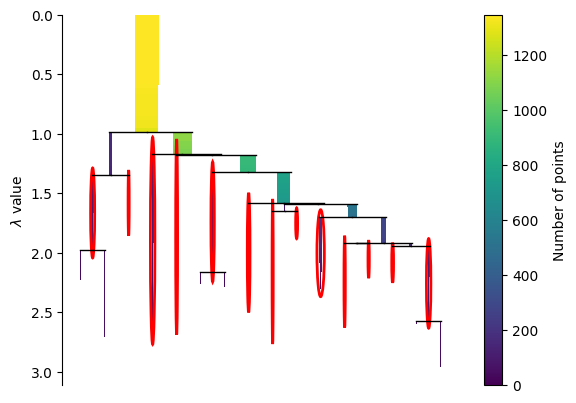

In [59]:
hdbscan_model.condensed_tree_.plot(select_clusters=True)

In [60]:
import plotly.express as px

In [61]:
assert len(topics) == len(df3)

In [62]:
df3['Topic'] = topics

In [63]:
df3.head()

,subReddit,Date,Datetime,Title,Body Text,Top Comment,Top Comment Reply 1,Top Comment Reply 2,Top Comment Reply 3,Top Comment Reply 4,Discussion,Contains_Keywords,Topic
0,diabetes_t2,2023-12-05 00:00:00,2023-12-05 23:25:00,cheapest way to get a cgm without insurance?,well after being told my insurance would cover...,,,,,,cheapest way get cgm without insurance well af...,True,3
1,diabetes_t2,2023-12-20 00:00:00,2023-12-20 05:13:00,libre 3 doesn’t stick,i’ve used the libre 3 for 3 months off and on....,,,,,,libre doesn stick used the libre for months of...,False,0
2,diabetes_t2,2023-12-23 00:00:00,2023-12-23 23:16:00,frustrated with libre 3,i just got off the phone with customer support...,,,,,,frustrated with libre just got off the phone w...,False,0
3,diabetes_t2,2023-12-23 00:00:00,2023-12-23 23:16:00,frustrated with libre 3,i just got off the phone with customer support...,,,,,,finger prick was like beyond frustrated the ou...,False,0
4,diabetes_t2,2023-12-23 00:00:00,2023-12-23 02:32:00,libre 3 graphs 3 weeks in,the first graph was my first full day with my ...,,,,,,libre graphs weeks the first graph was first f...,False,-1


***As seen below, we have imbalanced topic classes, which is expected from such a diverse text corpus scraped from social media. This will be accounted for in the supervised learning stage of classification.***

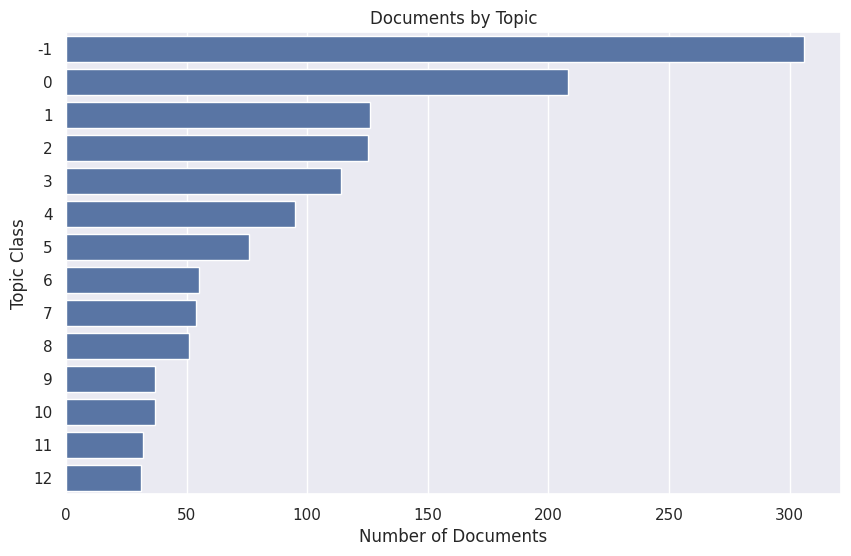

In [64]:
topic_counts = df3['Topic'].value_counts()
#data.drop(['Contains_Keywords'], axis=1)
# Create a count plot
sns.set(style="darkgrid")
plt.figure(figsize=(10, 6))
sns.countplot(y='Topic', data=df3, order = topic_counts.index)

# Labeling the plot
plt.title('Documents by Topic')
plt.xlabel('Number of Documents')
plt.ylabel('Topic Class')

# Show the plot
plt.show()

In [65]:
topic_distr, _ = BERTopic_model.approximate_distribution(texts)

100%|██████████| 2/2 [00:00<00:00,  2.89it/s]


In [66]:
BERTopic_model.visualize_distribution(topic_distr[1])

In [67]:
probs

array([[1.61434725e-308, 1.11265912e-308, 1.26138333e-308, ...,
        1.13676012e-308, 1.16549458e-308, 1.94270282e-308],
       [2.25258695e-001, 3.14188017e-002, 4.83441663e-002, ...,
        2.93388084e-002, 5.54968064e-002, 3.04599791e-002],
       [1.98289442e-001, 3.14877616e-002, 4.29246181e-002, ...,
        2.66657810e-002, 5.24094140e-002, 2.96671328e-002],
       ...,
       [2.72481517e-002, 6.20533572e-002, 1.79804471e-002, ...,
        1.48915080e-002, 4.04947645e-002, 4.82389203e-002],
       [2.72544012e-002, 5.22120627e-002, 1.81634448e-002, ...,
        1.52739289e-002, 4.42549121e-002, 5.71039917e-002],
       [3.06638105e-002, 1.06602056e-001, 1.98647761e-002, ...,
        1.58670999e-002, 3.58918109e-002, 3.73612016e-002]])

In [90]:
topic_distr, topic_token_distr = BERTopic_model.approximate_distribution(texts, calculate_tokens=True)
topic_dist_df = BERTopic_model.visualize_approximate_distribution(texts[1], topic_token_distr[1])


100%|██████████| 2/2 [00:02<00:00,  1.15s/it]


In [69]:
topic_dist_df

,libre,doesn,stick,used,the,libre,for,months,off,and,wish,had,more,consistently,but,never,had,unit,stay,more,than,days,been,frustrating,they,never,come,off,because,any,force,accident,they,just,become,loose,pregnant,now,and,would,like,able,wear,cgm,for,the,duration,pregnancy,what,gives,please,send,any,advice
0_low_libre_normal_morning,0.000,0.000,0.101,0.201,0.419,0.637,0.537,0.436,0.218,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2_libre_iphone_scan_ios,0.000,0.000,0.000,0.000,0.248,0.497,0.497,0.497,0.248,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3_libre_dexcom_without_need,0.000,0.000,0.000,0.000,0.185,0.370,0.370,0.370,0.185,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4_signal_alarm_alarms_libre,0.000,0.000,0.000,0.000,0.126,0.252,0.252,0.252,0.126,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
6_dexcom_libre_used_calibration,0.000,0.000,0.101,0.203,0.332,0.461,0.360,0.258,0.129,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
8_watch_data_libre_librelinkup,0.000,0.000,0.000,0.000,0.158,0.315,0.315,0.315,0.158,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
9_libre_juggluco_bluetooth_android,0.111,0.111,0.245,0.379,0.635,1.002,0.868,0.734,0.367,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
10_pixel_libre_android_vpn,0.000,0.000,0.000,0.000,0.218,0.436,0.436,0.436,0.218,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [114]:
BERTopic_model.visualize_term_rank(log_scale=True)

# **BERTopic Model Output Evaluation**
---



# **Coherence**
*By qualitatively comparing the representations generated by the topic model, it is evident that they are coherent and diverse, where each topic is represented by uniques phrases and terms related to specific niches in CGMs usage.*

In [70]:
coherence = BERTopic_model.get_topic_info(); coherence.head(10)

,Topic,Count,Name,Representation,KeyBERT,MMR,Representative_Docs
0,-1,306,-1_libre_dexcom_arm_low,"[libre, dexcom, arm, low, work, issues, well, ...","[alarms, alarm, alerts, dexcom, android, alert...","[libre, dexcom, arm, low, work, issues, well, ...",[telling replace sensor keep coming turning ph...
1,0,208,0_low_libre_normal_morning,"[low, libre, normal, morning, different, test,...","[diabetes, diabetic, sugars, dexcom, meter, al...","[libre, normal, morning, test, high, eat, accu...",[testedthis makes worthless purposes left full...
2,1,126,1_arm_skin_adhesive_compression,"[arm, skin, adhesive, compression, lows, compr...","[right arm, arm, skin tac, skin grip, upper ar...","[arm, skin, adhesive, compression lows, sleep,...",[pain level insertion with the use three years...
3,2,125,2_libre_iphone_scan_ios,"[libre, iphone, scan, ios, working, data, upda...","[libre iphone, apps, libreview, android, ios, ...","[libre, iphone, scan, ios, data, error, librel...",[experience with the libre far put first senso...
4,3,114,3_libre_dexcom_without_need,"[libre, dexcom, without, need, could, better, ...","[libre dexcom, switch libre, diabetes, diabeti...","[libre, dexcom, need, could, appointment, data...",[weird for not wanting cgm this bit rant but a...
5,4,95,4_signal_alarm_alarms_libre,"[signal, alarm, alarms, libre, android, settin...","[alarms, signal alarm, alarm, critical alerts,...","[signal, alarm, alarms, libre, settings, iphon...",[just have say the alarm mgdl ridiculous the p...
6,5,76,5_replacement_call_faulty_bad,"[replacement, call, faulty, bad, send, replace...","[defective, send replacement, faulty, replacem...","[replacement, call, faulty, bad, send, replace...",[contact abbott labs you likely have some from...
7,6,55,6_dexcom_libre_used_calibration,"[dexcom, libre, used, calibration, low, dexcom...","[dexcom libre, libre dexcom, dexcom, dexcoms, ...","[dexcom, libre, used, calibration, dexcom libr...",[did fuck did dexcom fuck went one half hour p...
8,7,54,7_transmitter_expired_expiration_libre,"[transmitter, expired, expiration, libre, expi...","[expired transmitter, signal error, date trans...","[transmitter, expired, libre, expires, error, ...",[libre sensor issue observation ive been havin...
9,8,51,8_watch_data_libre_librelinkup,"[watch, data, libre, librelinkup, watches, app...","[smart watches, smartwatch, apple watch dexcom...","[data, libre, librelinkup, watches, apple watc...",[libre data garmin watches hey yall using libr...


In [71]:
coherence_df = coherence

In [72]:
coherence_df

,Topic,Count,Name,Representation,KeyBERT,MMR,Representative_Docs
0,-1,306,-1_libre_dexcom_arm_low,"[libre, dexcom, arm, low, work, issues, well, ...","[alarms, alarm, alerts, dexcom, android, alert...","[libre, dexcom, arm, low, work, issues, well, ...",[telling replace sensor keep coming turning ph...
1,0,208,0_low_libre_normal_morning,"[low, libre, normal, morning, different, test,...","[diabetes, diabetic, sugars, dexcom, meter, al...","[libre, normal, morning, test, high, eat, accu...",[testedthis makes worthless purposes left full...
2,1,126,1_arm_skin_adhesive_compression,"[arm, skin, adhesive, compression, lows, compr...","[right arm, arm, skin tac, skin grip, upper ar...","[arm, skin, adhesive, compression lows, sleep,...",[pain level insertion with the use three years...
3,2,125,2_libre_iphone_scan_ios,"[libre, iphone, scan, ios, working, data, upda...","[libre iphone, apps, libreview, android, ios, ...","[libre, iphone, scan, ios, data, error, librel...",[experience with the libre far put first senso...
4,3,114,3_libre_dexcom_without_need,"[libre, dexcom, without, need, could, better, ...","[libre dexcom, switch libre, diabetes, diabeti...","[libre, dexcom, need, could, appointment, data...",[weird for not wanting cgm this bit rant but a...
5,4,95,4_signal_alarm_alarms_libre,"[signal, alarm, alarms, libre, android, settin...","[alarms, signal alarm, alarm, critical alerts,...","[signal, alarm, alarms, libre, settings, iphon...",[just have say the alarm mgdl ridiculous the p...
6,5,76,5_replacement_call_faulty_bad,"[replacement, call, faulty, bad, send, replace...","[defective, send replacement, faulty, replacem...","[replacement, call, faulty, bad, send, replace...",[contact abbott labs you likely have some from...
7,6,55,6_dexcom_libre_used_calibration,"[dexcom, libre, used, calibration, low, dexcom...","[dexcom libre, libre dexcom, dexcom, dexcoms, ...","[dexcom, libre, used, calibration, dexcom libr...",[did fuck did dexcom fuck went one half hour p...
8,7,54,7_transmitter_expired_expiration_libre,"[transmitter, expired, expiration, libre, expi...","[expired transmitter, signal error, date trans...","[transmitter, expired, libre, expires, error, ...",[libre sensor issue observation ive been havin...
9,8,51,8_watch_data_libre_librelinkup,"[watch, data, libre, librelinkup, watches, app...","[smart watches, smartwatch, apple watch dexcom...","[data, libre, librelinkup, watches, apple watc...",[libre data garmin watches hey yall using libr...


In [73]:
df3.to_excel('/content/drive/MyDrive/Colab Notebooks/BERTopic Model Outputs.xlsx')

In [74]:
coherence_df.to_excel('/content/drive/MyDrive/Colab Notebooks/BERTopic Coherence.xlsx')

# **Feed the Labelled Embedded Dataset to Classifiers**

In [75]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import f1_score, recall_score
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

In [76]:
 classifier_dataset = list(zip(embeds,topics))

In [77]:
 X_train, X_test, y_train, y_test = train_test_split(
     [embed[0] for embed in classifier_dataset],  # features (embeddings)
     [embed[1] for embed in classifier_dataset],  # labels (topics)
     test_size=0.2, random_state=42
 )

In [79]:
# nb_model = MultinomialNB()
# nb_model.fit(X_train,y_train)

# predictions_nb = nb_model.predict(X_test)

# #print("Multinomial NB Accuracy Score = ",accuracy_score(predictions_nb, Test_Y)*100)

# f1 = f1_score(y_test, predictions_nb, average='weighted')  # Use 'macro' or 'micro' if needed
# recall = recall_score(y_test, predictions_nb, average='weighted')  # Use 'macro' or 'micro' if needed
# print("Multinomial NB Accuracy Score = ",accuracy_score(predictions_nb, y_test)*100)
# print(f"Multinomial NB F1 Score = {f1 * 100}")
# print(f"Multinomial NB Recall = {recall * 100}")


In [105]:
svm_model = SVC(C=1.0, kernel='linear', degree=3, gamma='auto', class_weight = 'balanced', probability=True)
svm_model.fit(X_train,y_train)

predictions_svm = svm_model.predict(X_test)
svm_f1 = f1_score(y_test, predictions_svm, average='macro')  # Use 'macro' or 'micro' if needed
svm_recall = recall_score(y_test, predictions_svm, average='macro')  # Use 'macro' or 'micro' if needed
print("Nonlinear SVM Accuracy Score = ",accuracy_score(predictions_svm, y_test)*100)
print(f"Nonlinear SVM F1 Score = {svm_f1 * 100}")
print(f"Nonlinear SVM Recall = {svm_recall * 100}")
print(classification_report(y_test, predictions_svm))

Nonlinear SVM Accuracy Score =  65.92592592592592
Nonlinear SVM F1 Score = 67.82116567313051
Nonlinear SVM Recall = 73.3432103610675
              precision    recall  f1-score   support

          -1       0.67      0.31      0.42        65
           0       0.69      0.81      0.74        36
           1       0.76      0.88      0.81        25
           2       0.62      0.77      0.69        26
           3       0.70      0.73      0.72        26
           4       0.72      0.93      0.81        14
           5       0.69      0.56      0.62        16
           6       0.36      0.56      0.43         9
           7       0.33      0.86      0.48         7
           8       0.62      1.00      0.77        10
           9       0.83      0.56      0.67         9
          10       0.88      0.88      0.88         8
          11       0.88      0.58      0.70        12
          12       0.67      0.86      0.75         7

    accuracy                           0.66       270
 

In [106]:
log_reg_model = LogisticRegression(max_iter=1000, class_weight='balanced')
log_reg_model.fit(X_train, y_train)
predictions_log_reg = log_reg_model.predict(X_test)
log_reg_f1 = f1_score(y_test, predictions_log_reg, average='macro')  # Use 'macro' or 'micro' if needed
log_reg_recall = recall_score(y_test, predictions_log_reg, average='macro')

print(classification_report(y_test, predictions_log_reg))

              precision    recall  f1-score   support

          -1       0.88      0.22      0.35        65
           0       0.74      0.81      0.77        36
           1       0.68      0.84      0.75        25
           2       0.69      0.69      0.69        26
           3       0.83      0.73      0.78        26
           4       0.65      0.93      0.76        14
           5       0.62      0.62      0.62        16
           6       0.38      0.67      0.48         9
           7       0.33      1.00      0.50         7
           8       0.59      1.00      0.74        10
           9       0.67      0.67      0.67         9
          10       0.58      0.88      0.70         8
          11       0.70      0.58      0.64        12
          12       0.50      1.00      0.67         7

    accuracy                           0.64       270
   macro avg       0.63      0.76      0.65       270
weighted avg       0.72      0.64      0.62       270



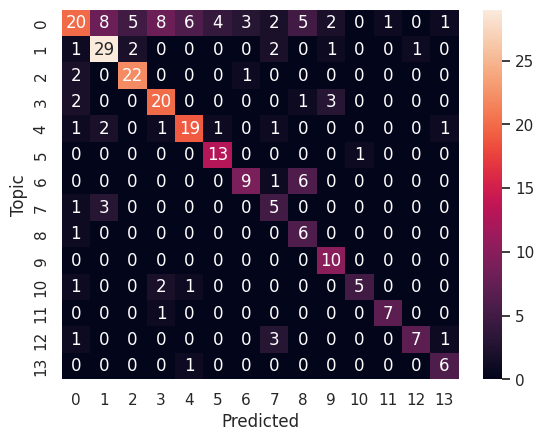

In [103]:
cm_svm = confusion_matrix(y_test, predictions_svm)
sns.heatmap(cm_svm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Topic')
plt.show()

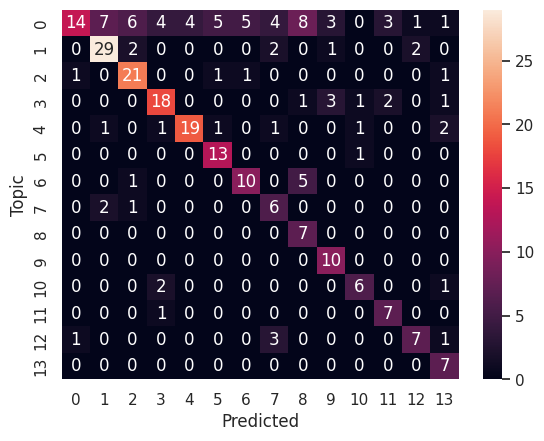

In [102]:
cm_logreg = confusion_matrix(y_test, predictions_log_reg)
sns.heatmap(cm_logreg, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Topic')
plt.show()

In [107]:
gbm_model = GradientBoostingClassifier(random_state=42)
gbm_model.fit(X_train, y_train)
gbm_predictions = gbm_model.predict(X_test)
gbm_f1 = f1_score(y_test, gbm_predictions, average='macro')  # Use 'macro' or 'micro' if needed
gbm_recall = recall_score(y_test, gbm_predictions, average='macro')


print(classification_report(y_test, gbm_predictions))

              precision    recall  f1-score   support

          -1       0.36      0.72      0.48        65
           0       0.61      0.64      0.62        36
           1       0.79      0.44      0.56        25
           2       0.61      0.42      0.50        26
           3       0.89      0.31      0.46        26
           4       0.70      0.50      0.58        14
           5       0.86      0.38      0.52        16
           6       0.38      0.33      0.35         9
           7       0.43      0.43      0.43         7
           8       0.73      0.80      0.76        10
           9       0.14      0.11      0.12         9
          10       0.67      0.25      0.36         8
          11       0.50      0.08      0.14        12
          12       0.60      0.43      0.50         7

    accuracy                           0.50       270
   macro avg       0.59      0.42      0.46       270
weighted avg       0.58      0.50      0.49       270



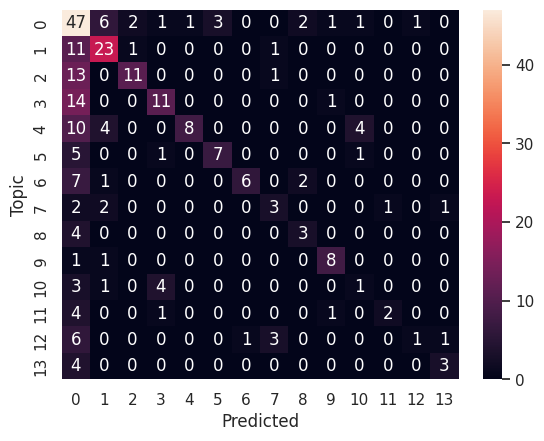

In [101]:
cm_gbm = confusion_matrix(y_test, gbm_predictions)
sns.heatmap(cm_gbm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Topic')
plt.show()

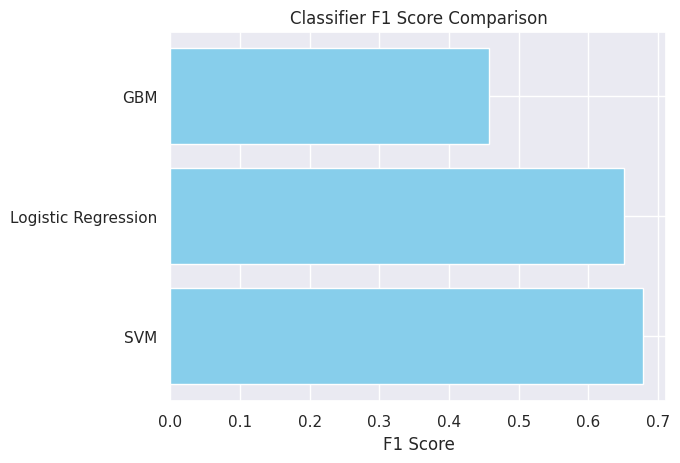

In [108]:
f1_scores = [svm_f1, log_reg_f1, gbm_f1]
recall_scores = [svm_recall, log_reg_recall, gbm_recall]
labels = ['SVM', 'Logistic Regression', 'GBM']

plt.barh(labels, f1_scores, color='skyblue')
plt.xlabel('F1 Score')
plt.title('Classifier F1 Score Comparison')
plt.show()

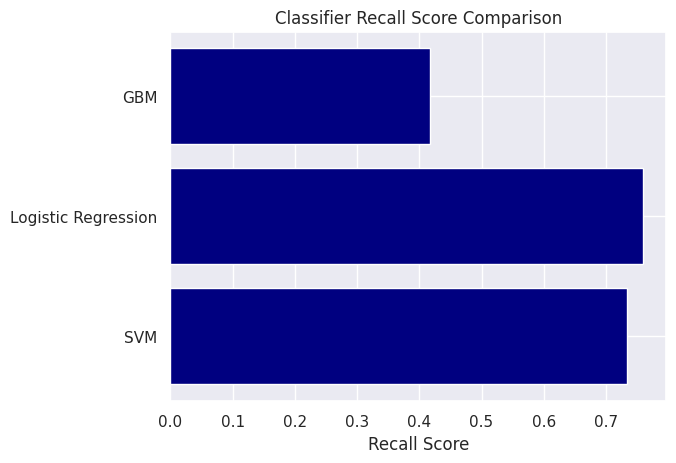

In [112]:
plt.barh(labels, recall_scores, color='navy')
plt.xlabel('Recall Score')
plt.title('Classifier Recall Score Comparison')
plt.show()